In [1]:
# import pyro
# import torch
# import torch.tensor as tensor
# import pyro.distributions as dist
# # from torch.distributions import Binomial, Gamma, Uniform
# from pyro.distributions import Binomial, Bernoulli, Categorical, Dirichlet, DirichletMultinomial, Beta, BetaBinomial, Uniform, Gamma, Multinomial

import numpy as np

import scipy
from skopt import gp_minimize 
from scipy.stats import binom as ScipyBinom
from matplotlib import pyplot
from torch import tensor

from collections import namedtuple
import time
seed = 0

In [556]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [661]:
from mvl import genData, likelihoods, bayes

In [25]:
import copy
resSim = {
        "allRes": None,
        "nEpochs": None,
        "bestRes": {
            "pis": None,
            "alphas": None,
            "PDV_c1true": None,
            "PDV_c2true": None,
            "PDV_cBothTrue": None,
            "PDV_c1inferred": None,
            "PDV_c2inferred": None,
            "PDV_cBothInferred": None,
        }
    }

cached6NormalSimRes = []

rrsSim = tensor([[2, 2, 1.5]])
pisSim = tensor([[.05, .05, .05]])

nCases = tensor([15e3, 15e3, 6e3])
nCtrls = tensor(5e5)
i = 0
for rrsSimRun in rrsSim:
    for pisSimRun in pisSim:
        afMeanRun = 1e-4
        generatingFn = genData.v6normal
        # In DSB:
        # 	No ID	ID	
        #         ASD+ADHD	684	217	
        #         ASD	3091	871	
        #         ADHD	3206	271	
        #         Control	5002	-	

        #         gnomAD	44779	(Non-Finnish Europeans in non-psychiatric exome subset)	

        #         Case total:	8340		
        #         Control total:	49781		
        # so we can use pDBoth = .1 * total_cases
        # needs tensor for shapes, otherwise "gamma_cpu not implemente for long", e.g rrShape=50.0 doesn't work...
        paramsRun = genData.genParams(rrMeans=rrsSimRun, pis=pisSimRun, afMean=afMeanRun, rrShape=tensor(50.), afShape=tensor(50.), nCases=nCases, nCtrls=nCtrls)[0]
        
        pDsRun = paramsRun["pDs"]
        pisRun = paramsRun["diseaseFractions"]
        print("params are:", paramsRun)
        
        cached6NormalSimRes.append({"params": paramsRun, "runs": []})
        for y in range(0, 10):
            start = time.time()
            r = generatingFn(**paramsRun)
            print("took", time.time() - start)
            
            resPointer = {
                **r,
                "generatingFn": generatingFn,
                "results": None,
            }

            cached6NormalSimRes[i]["runs"].append(resPointer)
            
            print(f"Run: {i}, {y}")
            
            xsRun = resPointer["altCounts"]
            afsRun = resPointer["afs"]
            affectedGenesRun = resPointer["affectedGenes"]
            unaffectedGenesRun = resPointer["unaffectedGenes"]

            runCostFnIdx = 16

            nEpochsRun = 10
            print("nEpochsRun", nEpochsRun)
            
            res = likelihoods.fitFnBivariateAnnealing(xsRun, pDsRun, nEpochs=nEpochsRun, minLLThresholdCount=20, debug=True, costFnIdx=runCostFnIdx)
            bestRes = res["params"][-1]

            inferredPis = tensor(bestRes[0:3]) # 3-vector
            inferredAlphas = tensor(bestRes[3:]) # 4-vector, idx0 is P(!D|V)

            #### Calculate actual ###
            component1Afs = afsRun[affectedGenesRun[0]]
            c1true = (component1Afs / afMeanRun).mean(0)

            component2Afs = afsRun[affectedGenesRun[1]]
            c2true = (component2Afs / afMeanRun).mean(0)

            componentBothAfs = afsRun[affectedGenesRun[2]]
            cBothTrue = (componentBothAfs / afMeanRun).mean(0)

            ### calculate inferred values
            pds = tensor([1-pDsRun.sum(), *pDsRun])
            alphas = inferredAlphas.numpy()
            c1inferred = Dirichlet(tensor([alphas[0], alphas[1], alphas[0], alphas[2]]) * pds).sample([10_000]).mean(0)
            c2inferred = Dirichlet(tensor([alphas[0], alphas[0], alphas[2], alphas[2]]) * pds).sample([10_000]).mean(0)
            cBothInferred = Dirichlet(tensor([alphas[0], (alphas[1] + alphas[3]), (alphas[2] + alphas[3]), (alphas[1] + alphas[2] + alphas[3])]) * pds).sample([10_000]).mean(0)

            print(f"\n\nrun {i} results for rrs: {rrsSimRun}, pis: {pisSimRun}")
            print("Inferred pis:", inferredPis)
            print("\nP(D|V) true ans in component 1:", c1true)
            print("P(D|V) inferred in component 1:", c1inferred)
            print("\nP(D|V) true ans in component 1:", c2true)
            print("P(D|V) inferred in component both:", c2inferred)
            print("\nP(D|V) true ans in component both:", cBothTrue)
            print("P(D|V) inferred in component both:", cBothInferred,"\n\n")

            resToStore = copy.deepcopy(resSim)
            resToStore["allRes"] = res
            resToStore["nEpochs"] = nEpochsRun
            br = resToStore["bestRes"]
            br["pis"] = inferredPis
            br["alphas"] = inferredAlphas
            br["PDV_c1true"] = c1true
            br["PDV_c2true"] = c2true
            br["PDV_cBothTrue"] = cBothTrue
            br["PDV_c1inferred"] = c1inferred
            br["PDV_c2inferred"] = c2inferred
            br["PDV_cBothInferred"] = cBothInferred

            resPointer["results"] = resToStore
        
        i += 1

pDs are: tensor([0.0280, 0.0280, 0.0112])
params are: {'nGenes': 20000, 'nCases': tensor([15000., 15000.,  6000.]), 'nCtrls': tensor(500000.), 'pDs': tensor([0.0280, 0.0280, 0.0112]), 'diseaseFractions': tensor([0.0500, 0.0500, 0.0500]), 'rrShape': tensor(50.), 'rrMeans': tensor([2.0000, 2.0000, 1.5000]), 'afShape': tensor(50.), 'afMean': 0.0001}
TESTING WITH: nCases tensor([15000., 15000.,  6000.]) nCtrls tensor(500000.) rrMeans tensor([2.0000, 2.0000, 1.5000]) rrShape tensor(50.) afMean 0.0001 afShape tensor(50.) diseaseFractions tensor([0.0500, 0.0500, 0.0500]) pDs tensor([0.0280, 0.0280, 0.0112])
tensor([[4.3519, 2.7890, 5.5548],
        [2.8917, 4.4436, 5.2706],
        [3.8678, 4.4712, 5.3107],
        ...,
        [4.7168, 4.2715, 6.7835],
        [4.6791, 3.9330, 4.3859],
        [2.6210, 1.9142, 4.4797]], dtype=torch.float64)
startIndices [0, tensor(1000.), tensor(2000.)] endIndices tensor([1000., 2000., 3000.])
totalSamples 536000
took 8.120481967926025
Run: 0, 0
nEpochsRun 1

/Users/alexkotlar/projects/tada/mvl/likelihoods.py:257: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  altCountsFlat = tensor(altCountsFlat)


best ll: 91056.366085773, bestParams: [0.021506596, 0.032269087, 0.032386456, 7456.216, 13592.753, 24910.842, 18917.502]
epoch 0
     fun: 90678.94727806201
 message: ['Maximum number of iteration reached']
    nfev: 18988
    nhev: 0
     nit: 1000
    njev: 0
  status: 0
 success: True
       x: array([4.49893948e-02, 4.43790738e-02, 4.08915328e-02, 8.60818913e+03,
       2.44622045e+04, 2.48735515e+04, 2.14801207e+04])
best ll: 91026.39509861523, bestParams: [0.11172657, 0.090561226, 0.053274393, 6340.836, 12428.718, 19741.955, 19129.791]
epoch 1
     fun: 90680.17847220492
 message: ['Maximum number of iteration reached']
    nfev: 18535
    nhev: 0
     nit: 1000
    njev: 0
  status: 0
 success: True
       x: array([4.87069860e-02, 4.87180474e-02, 4.18491463e-02, 9.10768397e+03,
       2.46671325e+04, 2.48377120e+04, 2.38725486e+04])
minPrevious 90678.94727806201
best ll: 90935.85000957745, bestParams: [0.049423933, 0.009214227, 0.066587955, 8144.4087, 14092.45, 19146.107, 19184

/Users/alexkotlar/projects/tada/mvl/likelihoods.py:257: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  altCountsFlat = tensor(altCountsFlat)


best ll: 91239.19500249799, bestParams: [0.07369001, 0.04880978, 0.06687576, 4858.3516, 16533.74, 12923.512, 14745.741]
epoch 0
     fun: 90861.78577540864
 message: ['Maximum number of iteration reached']
    nfev: 28688
    nhev: 0
     nit: 1000
    njev: 0
  status: 0
 success: True
       x: array([4.39126641e-02, 4.43361706e-02, 4.16877774e-02, 6.30811938e+03,
       1.80875402e+04, 1.85093776e+04, 1.54715766e+04])
best ll: 91471.4697084639, bestParams: [0.015408821, 0.025966937, 0.018776404, 6470.502, 16699.875, 22305.629, 7609.0425]
epoch 1
     fun: 90860.74902260769
 message: ['Maximum number of iteration reached']
    nfev: 21083
    nhev: 0
     nit: 1000
    njev: 0
  status: 0
 success: True
       x: array([4.31587597e-02, 4.55204559e-02, 4.21324394e-02, 8.65442240e+03,
       2.47671562e+04, 2.49529431e+04, 2.13176385e+04])
minPrevious 90861.78577540864
better by at >= 1; new ll:      fun: 90860.74902260769
 message: ['Maximum number of iteration reached']
    nfev: 210

/Users/alexkotlar/projects/tada/mvl/likelihoods.py:257: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  altCountsFlat = tensor(altCountsFlat)


best ll: 91007.93332294546, bestParams: [0.0857708, 0.027353209, 0.056023873, 8389.133, 21786.912, 16894.488, 17575.045]
epoch 0
     fun: 90741.29185131165
 message: ['Maximum number of iteration reached']
    nfev: 16482
    nhev: 0
     nit: 1000
    njev: 0
  status: 0
 success: True
       x: array([5.23376169e-02, 4.93065527e-02, 4.38559895e-02, 9.47084934e+03,
       2.48940172e+04, 2.48822170e+04, 2.49999981e+04])
best ll: 91224.73436774276, bestParams: [0.043282628, 0.04283247, 0.015615053, 3965.399, 15119.752, 11289.01, 20118.45]
epoch 1
     fun: 90968.17657566987
 message: ['Maximum number of iteration reached']
    nfev: 39572
    nhev: 0
     nit: 1000
    njev: 0
  status: 0
 success: True
       x: array([7.99538244e-02, 2.93838522e-01, 5.58080675e-02, 5.08857742e+03,
       9.48498524e+03, 6.15838872e+03, 1.74503829e+04])
minPrevious 90741.29185131165
best ll: 90881.52796996137, bestParams: [0.057814863, 0.036603197, 0.048284452, 6125.3677, 14977.148, 11782.217, 16754.

/Users/alexkotlar/projects/tada/mvl/likelihoods.py:257: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  altCountsFlat = tensor(altCountsFlat)


best ll: 91021.23597877396, bestParams: [0.02387655, 0.09362935, 0.0531731, 8440.324, 13937.0, 11477.793, 16246.775]
epoch 0
     fun: 90367.46646443212
 message: ['Maximum number of iteration reached']
    nfev: 18738
    nhev: 0
     nit: 1000
    njev: 0
  status: 0
 success: True
       x: array([3.85798503e-02, 3.12189972e-02, 4.14406663e-02, 7.79360605e+03,
       2.38725780e+04, 2.46992225e+04, 1.68480061e+04])
best ll: 90814.01155907288, bestParams: [0.092853814, 0.079595976, 0.09696471, 9648.206, 12964.165, 13710.112, 22609.943]
epoch 1
     fun: 90370.16992066184
 message: ['Maximum number of iteration reached']
    nfev: 20256
    nhev: 0
     nit: 1000
    njev: 0
  status: 0
 success: True
       x: array([4.06782851e-02, 3.05888247e-02, 4.18256058e-02, 3.30614673e+03,
       9.80870940e+03, 1.04315332e+04, 7.28013746e+03])
minPrevious 90367.46646443212
best ll: 90693.35079318719, bestParams: [0.05039767, 0.07389942, 0.05925788, 5015.5117, 11736.682, 7729.9805, 10372.028]


/Users/alexkotlar/projects/tada/mvl/likelihoods.py:257: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  altCountsFlat = tensor(altCountsFlat)


best ll: 91345.08023811383, bestParams: [0.06884586, 0.015770206, 0.08335171, 3087.4746, 10631.862, 13740.989, 2484.048]
epoch 0
     fun: 90879.9946159658
 message: ['Maximum number of iteration reached']
    nfev: 23081
    nhev: 0
     nit: 1000
    njev: 0
  status: 0
 success: True
       x: array([4.24280571e-02, 4.00968936e-02, 3.89581658e-02, 6.72886260e+03,
       2.08850194e+04, 2.07802951e+04, 1.66012855e+04])
best ll: 90987.4655751705, bestParams: [0.028817432, 0.02610038, 0.034790974, 7775.3364, 23897.207, 21864.736, 15247.122]
epoch 1
     fun: 90879.06292379234
 message: ['Maximum number of iteration reached']
    nfev: 19756
    nhev: 0
     nit: 1000
    njev: 0
  status: 0
 success: True
       x: array([4.14930094e-02, 3.82729929e-02, 3.86535609e-02, 7.50684449e+03,
       2.37203578e+04, 2.38252110e+04, 1.80371150e+04])
minPrevious 90879.9946159658
best ll: 91464.60088640705, bestParams: [0.07165316, 0.0929115, 0.01606413, 4874.1367, 14892.382, 17925.348, 7632.4253]

/Users/alexkotlar/projects/tada/mvl/likelihoods.py:257: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  altCountsFlat = tensor(altCountsFlat)


best ll: 90857.78330615468, bestParams: [0.065798305, 0.01862657, 0.08375965, 6535.119, 18724.98, 18402.521, 23863.832]
epoch 0
     fun: 90574.54329233595
 message: ['Maximum number of iteration reached']
    nfev: 16861
    nhev: 0
     nit: 1000
    njev: 0
  status: 0
 success: True
       x: array([8.85348671e-01, 5.79907422e-02, 5.65029340e-02, 4.43107258e+03,
       4.70193766e+03, 8.01621143e+03, 1.52672211e+04])
best ll: 90647.02931454076, bestParams: [0.006345086, 0.025668247, 0.041042943, 3689.1306, 14496.478, 9464.404, 3974.9004]
epoch 1
     fun: 90346.79818100025
 message: ['Maximum number of iteration reached']
    nfev: 22437
    nhev: 0
     nit: 1000
    njev: 0
  status: 0
 success: True
       x: array([4.38988240e-02, 3.73832477e-02, 4.08481269e-02, 5.29178931e+03,
       1.53774819e+04, 1.54631092e+04, 1.26597146e+04])
minPrevious 90574.54329233595
better by at >= 1; new ll:      fun: 90346.79818100025
 message: ['Maximum number of iteration reached']
    nfev: 22

/Users/alexkotlar/projects/tada/mvl/likelihoods.py:257: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  altCountsFlat = tensor(altCountsFlat)


best ll: 91089.27396093101, bestParams: [0.0075157364, 0.016659165, 0.0528355, 6167.8413, 16675.133, 23120.914, 2626.2808]
epoch 0
     fun: 90528.09146807808
 message: ['Maximum number of iteration reached']
    nfev: 21301
    nhev: 0
     nit: 1000
    njev: 0
  status: 0
 success: True
       x: array([4.22089041e-02, 4.04911316e-02, 4.09398703e-02, 7.87634233e+03,
       2.31800900e+04, 2.34644446e+04, 1.90780530e+04])
best ll: 90732.33126287756, bestParams: [0.025354784, 0.034044795, 0.03233444, 3831.9717, 18235.803, 15221.045, 8825.367]
epoch 1
     fun: 90527.19937601546
 message: ['Maximum number of iteration reached']
    nfev: 19413
    nhev: 0
     nit: 1000
    njev: 0
  status: 0
 success: True
       x: array([4.15413749e-02, 3.99949216e-02, 4.07060772e-02, 7.98855681e+03,
       2.37755273e+04, 2.40322552e+04, 1.91271434e+04])
minPrevious 90528.09146807808
best ll: 91108.88783821915, bestParams: [0.086679004, 0.067132905, 0.09949029, 7799.4536, 21237.266, 20044.95, 2024

/Users/alexkotlar/projects/tada/mvl/likelihoods.py:257: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  altCountsFlat = tensor(altCountsFlat)


best ll: 91243.91071417881, bestParams: [0.040498573, 0.039992083, 0.033642173, 6753.6836, 15692.065, 21096.775, 11753.506]
epoch 0
     fun: 91035.2144862661
 message: ['Maximum number of iteration reached']
    nfev: 21164
    nhev: 0
     nit: 1000
    njev: 0
  status: 0
 success: True
       x: array([4.56112050e-02, 5.15920592e-02, 4.19819102e-02, 8.88284249e+03,
       2.49907590e+04, 2.48726630e+04, 2.23069026e+04])
best ll: 91357.54566372334, bestParams: [0.040997185, 0.04618633, 0.0838608, 10846.453, 19839.768, 20632.074, 23618.115]
epoch 1
     fun: 91032.30772549672
 message: ['Maximum number of iteration reached']
    nfev: 26802
    nhev: 0
     nit: 1000
    njev: 0
  status: 0
 success: True
       x: array([4.40870682e-02, 4.61593746e-02, 4.11538469e-02, 8.28519028e+03,
       2.40384533e+04, 2.47662828e+04, 1.98040363e+04])
minPrevious 91035.2144862661
better by at >= 1; new ll:      fun: 91032.30772549672
 message: ['Maximum number of iteration reached']
    nfev: 26

/Users/alexkotlar/projects/tada/mvl/likelihoods.py:257: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  altCountsFlat = tensor(altCountsFlat)


best ll: 91167.15270193382, bestParams: [0.014420534, 0.012763254, 0.08490746, 10409.463, 14869.195, 12726.8955, 24758.049]
epoch 0
     fun: 90664.13815521165
 message: ['Maximum number of iteration reached']
    nfev: 18871
    nhev: 0
     nit: 1000
    njev: 0
  status: 0
 success: True
       x: array([4.50519321e-02, 4.80974897e-02, 4.37722990e-02, 9.33124432e+03,
       2.49952647e+04, 2.48946095e+04, 2.44922474e+04])
best ll: 91064.46507395245, bestParams: [0.13599314, 0.0092406655, 0.06631607, 5395.3354, 13053.832, 21606.041, 11194.925]
epoch 1
     fun: 90658.51054391943
 message: ['Maximum number of iteration reached']
    nfev: 21778
    nhev: 0
     nit: 1000
    njev: 0
  status: 0
 success: True
       x: array([3.97539028e-02, 3.85180081e-02, 4.21989798e-02, 5.29648514e+03,
       1.53948253e+04, 1.60815565e+04, 1.24519796e+04])
minPrevious 90664.13815521165
better by at >= 1; new ll:      fun: 90658.51054391943
 message: ['Maximum number of iteration reached']
    nfev

KeyboardInterrupt: 

In [29]:
import copy
resSim = {
        "allRes": None,
        "nEpochs": None,
        "bestRes": {
            "pis": None,
            "alphas": None,
            "PDV_c1true": None,
            "PDV_c2true": None,
            "PDV_cBothTrue": None,
            "PDV_c1inferred": None,
            "PDV_c2inferred": None,
            "PDV_cBothInferred": None,
        }
    }

cached6NormalSimResNonAnnealing = []

rrsSim = tensor([[2, 2, 1.5]])
pisSim = tensor([[.05, .05, .05]])

nCases = tensor([15e3, 15e3, 6e3])
nCtrls = tensor(5e5)
i = 0
for rrsSimRun in rrsSim:
    for pisSimRun in pisSim:
        afMeanRun = 1e-4
        generatingFn = genData.v6normal
        # In DSB:
        # 	No ID	ID	
        #         ASD+ADHD	684	217	
        #         ASD	3091	871	
        #         ADHD	3206	271	
        #         Control	5002	-	

        #         gnomAD	44779	(Non-Finnish Europeans in non-psychiatric exome subset)	

        #         Case total:	8340		
        #         Control total:	49781		
        # so we can use pDBoth = .1 * total_cases
        # needs tensor for shapes, otherwise "gamma_cpu not implemente for long", e.g rrShape=50.0 doesn't work...
        paramsRun = genData.genParams(rrMeans=rrsSimRun, pis=pisSimRun, afMean=afMeanRun, rrShape=tensor(50.), afShape=tensor(50.), nCases=nCases, nCtrls=nCtrls)[0]
        
        pDsRun = paramsRun["pDs"]
        pisRun = paramsRun["diseaseFractions"]
        print("params are:", paramsRun)
        
        cached6NormalSimResNonAnnealing.append({"params": paramsRun, "runs": []})
        for y in range(0, 10):
            start = time.time()
            r = generatingFn(**paramsRun)
            print("took", time.time() - start)
            
            resPointer = {
                **r,
                "generatingFn": generatingFn,
                "results": None,
            }

            cached6NormalSimResNonAnnealing[i]["runs"].append(resPointer)
            
            print(f"Run: {i}, {y}")
            
            xsRun = resPointer["altCounts"]
            afsRun = resPointer["afs"]
            affectedGenesRun = resPointer["affectedGenes"]
            unaffectedGenesRun = resPointer["unaffectedGenes"]

            runCostFnIdx = 16

            nEpochsRun = 10
            print("nEpochsRun", nEpochsRun)
            
            res = likelihoods.fitFnBivariate(xsRun, pDsRun, nEpochs=nEpochsRun, minLLThresholdCount=20, debug=True, costFnIdx=runCostFnIdx)
            bestRes = res["params"][-1]

            inferredPis = tensor(bestRes[0:3]) # 3-vector
            inferredAlphas = tensor(bestRes[3:]) # 4-vector, idx0 is P(!D|V)

            #### Calculate actual ###
            component1Afs = afsRun[affectedGenesRun[0]]
            c1true = (component1Afs / afMeanRun).mean(0)

            component2Afs = afsRun[affectedGenesRun[1]]
            c2true = (component2Afs / afMeanRun).mean(0)

            componentBothAfs = afsRun[affectedGenesRun[2]]
            cBothTrue = (componentBothAfs / afMeanRun).mean(0)

            ### calculate inferred values
            pds = tensor([1-pDsRun.sum(), *pDsRun])
            alphas = inferredAlphas.numpy()
            c1inferred = Dirichlet(tensor([alphas[0], alphas[1], alphas[0], alphas[2]]) * pds).sample([10_000]).mean(0)
            c2inferred = Dirichlet(tensor([alphas[0], alphas[0], alphas[2], alphas[2]]) * pds).sample([10_000]).mean(0)
            cBothInferred = Dirichlet(tensor([alphas[0], (alphas[1] + alphas[3]), (alphas[2] + alphas[3]), (alphas[1] + alphas[2] + alphas[3])]) * pds).sample([10_000]).mean(0)

            print(f"\n\nrun {i} results for rrs: {rrsSimRun}, pis: {pisSimRun}")
            print("Inferred pis:", inferredPis)
            print("\nP(D|V) true ans in component 1:", c1true)
            print("P(D|V) inferred in component 1:", c1inferred)
            print("\nP(D|V) true ans in component 1:", c2true)
            print("P(D|V) inferred in component both:", c2inferred)
            print("\nP(D|V) true ans in component both:", cBothTrue)
            print("P(D|V) inferred in component both:", cBothInferred,"\n\n")

            resToStore = copy.deepcopy(resSim)
            resToStore["allRes"] = res
            resToStore["nEpochs"] = nEpochsRun
            br = resToStore["bestRes"]
            br["pis"] = inferredPis
            br["alphas"] = inferredAlphas
            br["PDV_c1true"] = c1true
            br["PDV_c2true"] = c2true
            br["PDV_cBothTrue"] = cBothTrue
            br["PDV_c1inferred"] = c1inferred
            br["PDV_c2inferred"] = c2inferred
            br["PDV_cBothInferred"] = cBothInferred

            resPointer["results"] = resToStore
        
        i += 1

pDs are: tensor([0.0280, 0.0280, 0.0112])
params are: {'nGenes': 20000, 'nCases': tensor([15000., 15000.,  6000.]), 'nCtrls': tensor(500000.), 'pDs': tensor([0.0280, 0.0280, 0.0112]), 'diseaseFractions': tensor([0.0500, 0.0500, 0.0500]), 'rrShape': tensor(50.), 'rrMeans': tensor([2.0000, 2.0000, 1.5000]), 'afShape': tensor(50.), 'afMean': 0.0001}
TESTING WITH: nCases tensor([15000., 15000.,  6000.]) nCtrls tensor(500000.) rrMeans tensor([2.0000, 2.0000, 1.5000]) rrShape tensor(50.) afMean 0.0001 afShape tensor(50.) diseaseFractions tensor([0.0500, 0.0500, 0.0500]) pDs tensor([0.0280, 0.0280, 0.0112])
tensor([[2.0478, 2.3230, 4.9419],
        [1.1123, 3.1260, 6.4751],
        [3.7432, 4.8883, 4.0865],
        ...,
        [2.3440, 2.6389, 4.7504],
        [3.1413, 3.7973, 5.2277],
        [2.2387, 4.0079, 4.0649]], dtype=torch.float64)
startIndices [0, tensor(1000.), tensor(2000.)] endIndices tensor([1000., 2000., 3000.])
totalSamples 536000
took 8.850098848342896
Run: 0, 0
nEpochsRun 1

/Users/alexkotlar/projects/tada/mvl/likelihoods.py:257: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  altCountsFlat = tensor(altCountsFlat)


best ll: 91172.32504614866, bestParams: [0.013028687, 0.04237689, 0.055741724, 11929.878, 23005.342, 24812.355, 19184.58]
epoch 0
 final_simplex: (array([[1.44827568e-02, 4.20886696e-02, 5.23620101e-02, 8.85204497e+03,
        2.80864800e+04, 2.54391201e+04, 1.98356475e+04],
       [1.44827568e-02, 4.20886697e-02, 5.23620101e-02, 8.85204497e+03,
        2.80864800e+04, 2.54391201e+04, 1.98356475e+04],
       [1.44827568e-02, 4.20886695e-02, 5.23620101e-02, 8.85204496e+03,
        2.80864801e+04, 2.54391201e+04, 1.98356475e+04],
       [1.44827568e-02, 4.20886697e-02, 5.23620101e-02, 8.85204497e+03,
        2.80864800e+04, 2.54391201e+04, 1.98356475e+04],
       [1.44827568e-02, 4.20886695e-02, 5.23620101e-02, 8.85204496e+03,
        2.80864800e+04, 2.54391201e+04, 1.98356475e+04],
       [1.44827568e-02, 4.20886695e-02, 5.23620101e-02, 8.85204495e+03,
        2.80864801e+04, 2.54391201e+04, 1.98356475e+04],
       [1.44827568e-02, 4.20886695e-02, 5.23620101e-02, 8.85204495e+03,
       

/Users/alexkotlar/projects/tada/mvl/likelihoods.py:257: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  altCountsFlat = tensor(altCountsFlat)


best ll: 90741.90852394194, bestParams: [0.07122339, 0.0030399286, 0.054159407, 10150.92, 21346.87, 23431.73, 21332.012]
epoch 0
 final_simplex: (array([[6.75587190e-02, 3.35212914e-03, 5.38820010e-02, 8.95523095e+03,
        2.17844698e+04, 2.55800586e+04, 2.21139824e+04],
       [6.75587191e-02, 3.35212913e-03, 5.38820010e-02, 8.95523096e+03,
        2.17844698e+04, 2.55800586e+04, 2.21139824e+04],
       [6.75587191e-02, 3.35212913e-03, 5.38820010e-02, 8.95523095e+03,
        2.17844698e+04, 2.55800586e+04, 2.21139824e+04],
       [6.75587193e-02, 3.35212913e-03, 5.38820010e-02, 8.95523096e+03,
        2.17844698e+04, 2.55800585e+04, 2.21139824e+04],
       [6.75587193e-02, 3.35212913e-03, 5.38820010e-02, 8.95523096e+03,
        2.17844698e+04, 2.55800585e+04, 2.21139824e+04],
       [6.75587191e-02, 3.35212914e-03, 5.38820011e-02, 8.95523095e+03,
        2.17844697e+04, 2.55800586e+04, 2.21139824e+04],
       [6.75587194e-02, 3.35212913e-03, 5.38820010e-02, 8.95523096e+03,
        

/Users/alexkotlar/projects/tada/mvl/likelihoods.py:257: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  altCountsFlat = tensor(altCountsFlat)


best ll: 90729.31401045548, bestParams: [0.04714876, 0.012392071, 0.053447075, 7013.6914, 12085.93, 22692.54, 17837.424]
epoch 0
 final_simplex: (array([[3.33117250e-02, 2.04074664e-02, 4.59170420e-02, 5.82361142e+03,
        1.80858056e+04, 2.06137097e+04, 9.83484979e+03],
       [3.33117247e-02, 2.04074666e-02, 4.59170423e-02, 5.82361138e+03,
        1.80858055e+04, 2.06137097e+04, 9.83484977e+03],
       [3.33117250e-02, 2.04074665e-02, 4.59170422e-02, 5.82361140e+03,
        1.80858055e+04, 2.06137097e+04, 9.83484981e+03],
       [3.33117246e-02, 2.04074667e-02, 4.59170427e-02, 5.82361135e+03,
        1.80858055e+04, 2.06137097e+04, 9.83484984e+03],
       [3.33117235e-02, 2.04074668e-02, 4.59170428e-02, 5.82361134e+03,
        1.80858056e+04, 2.06137097e+04, 9.83484973e+03],
       [3.33117244e-02, 2.04074666e-02, 4.59170425e-02, 5.82361138e+03,
        1.80858055e+04, 2.06137097e+04, 9.83484982e+03],
       [3.33117253e-02, 2.04074665e-02, 4.59170425e-02, 5.82361138e+03,
        

/Users/alexkotlar/projects/tada/mvl/likelihoods.py:257: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  altCountsFlat = tensor(altCountsFlat)


best ll: 90687.73814175435, bestParams: [0.020037124, 0.0016247494, 0.040445533, 5294.021, 10814.926, 12456.389, 21372.918]
epoch 0
 final_simplex: (array([[6.23123949e-02, 6.27163447e-03, 4.18681284e-02, 1.50217719e+03,
        4.00664783e+03, 5.09986993e+03, 3.23227687e+03],
       [6.23123948e-02, 6.27163447e-03, 4.18681283e-02, 1.50217718e+03,
        4.00664785e+03, 5.09986989e+03, 3.23227688e+03],
       [6.23123949e-02, 6.27163448e-03, 4.18681282e-02, 1.50217718e+03,
        4.00664787e+03, 5.09986996e+03, 3.23227683e+03],
       [6.23123949e-02, 6.27163448e-03, 4.18681282e-02, 1.50217718e+03,
        4.00664788e+03, 5.09986997e+03, 3.23227683e+03],
       [6.23123949e-02, 6.27163448e-03, 4.18681281e-02, 1.50217718e+03,
        4.00664789e+03, 5.09986998e+03, 3.23227682e+03],
       [6.23123947e-02, 6.27163449e-03, 4.18681278e-02, 1.50217718e+03,
        4.00664791e+03, 5.09986998e+03, 3.23227682e+03],
       [6.23123950e-02, 6.27163449e-03, 4.18681283e-02, 1.50217718e+03,
     

/Users/alexkotlar/projects/tada/mvl/likelihoods.py:257: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  altCountsFlat = tensor(altCountsFlat)


best ll: 91158.47332401684, bestParams: [0.014721362, 0.040411327, 0.04527418, 4070.2559, 20366.186, 16429.271, 14589.068]
epoch 0
 final_simplex: (array([[1.72872707e-02, 4.17161449e-02, 4.35534533e-02, 5.36272840e+03,
        1.76994581e+04, 1.59514174e+04, 1.15286871e+04],
       [1.72872707e-02, 4.17161449e-02, 4.35534529e-02, 5.36272840e+03,
        1.76994581e+04, 1.59514173e+04, 1.15286872e+04],
       [1.72872707e-02, 4.17161449e-02, 4.35534536e-02, 5.36272840e+03,
        1.76994581e+04, 1.59514175e+04, 1.15286870e+04],
       [1.72872708e-02, 4.17161450e-02, 4.35534534e-02, 5.36272838e+03,
        1.76994581e+04, 1.59514174e+04, 1.15286871e+04],
       [1.72872707e-02, 4.17161450e-02, 4.35534530e-02, 5.36272840e+03,
        1.76994581e+04, 1.59514174e+04, 1.15286871e+04],
       [1.72872707e-02, 4.17161449e-02, 4.35534535e-02, 5.36272840e+03,
        1.76994581e+04, 1.59514175e+04, 1.15286871e+04],
       [1.72872706e-02, 4.17161451e-02, 4.35534529e-02, 5.36272841e+03,
      

/Users/alexkotlar/projects/tada/mvl/likelihoods.py:257: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  altCountsFlat = tensor(altCountsFlat)


best ll: 91090.3604514042, bestParams: [0.043571133, 0.095463604, 0.0505203, 5832.7603, 16079.994, 12313.426, 8391.266]
epoch 0
 final_simplex: (array([[3.59893537e-02, 5.64996138e-02, 4.31957835e-02, 5.33859643e+03,
        1.57706471e+04, 1.39949641e+04, 1.36028399e+04],
       [3.59893536e-02, 5.64996138e-02, 4.31957836e-02, 5.33859644e+03,
        1.57706472e+04, 1.39949641e+04, 1.36028399e+04],
       [3.59893539e-02, 5.64996138e-02, 4.31957834e-02, 5.33859642e+03,
        1.57706471e+04, 1.39949641e+04, 1.36028399e+04],
       [3.59893536e-02, 5.64996138e-02, 4.31957836e-02, 5.33859643e+03,
        1.57706472e+04, 1.39949641e+04, 1.36028399e+04],
       [3.59893536e-02, 5.64996140e-02, 4.31957838e-02, 5.33859643e+03,
        1.57706471e+04, 1.39949641e+04, 1.36028399e+04],
       [3.59893536e-02, 5.64996140e-02, 4.31957838e-02, 5.33859643e+03,
        1.57706471e+04, 1.39949641e+04, 1.36028399e+04],
       [3.59893535e-02, 5.64996143e-02, 4.31957837e-02, 5.33859643e+03,
        1

/Users/alexkotlar/projects/tada/mvl/likelihoods.py:257: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  altCountsFlat = tensor(altCountsFlat)


best ll: 90705.78630343798, bestParams: [0.042797178, 0.03189743, 0.0427665, 7865.0444, 19529.307, 18785.924, 20957.984]
epoch 0
 final_simplex: (array([[4.53094590e-02, 3.29430425e-02, 4.13675399e-02, 7.16461645e+03,
        2.07289734e+04, 2.24192353e+04, 1.77718440e+04],
       [4.53094590e-02, 3.29430424e-02, 4.13675399e-02, 7.16461645e+03,
        2.07289734e+04, 2.24192353e+04, 1.77718440e+04],
       [4.53094589e-02, 3.29430424e-02, 4.13675399e-02, 7.16461645e+03,
        2.07289733e+04, 2.24192353e+04, 1.77718440e+04],
       [4.53094590e-02, 3.29430424e-02, 4.13675401e-02, 7.16461646e+03,
        2.07289734e+04, 2.24192353e+04, 1.77718439e+04],
       [4.53094590e-02, 3.29430424e-02, 4.13675400e-02, 7.16461645e+03,
        2.07289734e+04, 2.24192353e+04, 1.77718440e+04],
       [4.53094589e-02, 3.29430424e-02, 4.13675399e-02, 7.16461645e+03,
        2.07289734e+04, 2.24192353e+04, 1.77718441e+04],
       [4.53094589e-02, 3.29430424e-02, 4.13675400e-02, 7.16461645e+03,
        

/Users/alexkotlar/projects/tada/mvl/likelihoods.py:257: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  altCountsFlat = tensor(altCountsFlat)


best ll: 90698.00966445002, bestParams: [0.03601381, 0.05376842, 0.037697803, 4858.81, 17559.475, 15117.588, 10296.187]
epoch 0
 final_simplex: (array([[3.70708269e-02, 4.24062757e-02, 4.20397106e-02, 5.12695246e+03,
        1.55116198e+04, 1.47037155e+04, 1.20498578e+04],
       [3.70708268e-02, 4.24062756e-02, 4.20397107e-02, 5.12695245e+03,
        1.55116197e+04, 1.47037155e+04, 1.20498578e+04],
       [3.70708269e-02, 4.24062757e-02, 4.20397107e-02, 5.12695246e+03,
        1.55116198e+04, 1.47037155e+04, 1.20498577e+04],
       [3.70708269e-02, 4.24062757e-02, 4.20397106e-02, 5.12695247e+03,
        1.55116198e+04, 1.47037155e+04, 1.20498577e+04],
       [3.70708268e-02, 4.24062756e-02, 4.20397106e-02, 5.12695245e+03,
        1.55116197e+04, 1.47037155e+04, 1.20498578e+04],
       [3.70708268e-02, 4.24062758e-02, 4.20397103e-02, 5.12695247e+03,
        1.55116197e+04, 1.47037155e+04, 1.20498578e+04],
       [3.70708268e-02, 4.24062756e-02, 4.20397105e-02, 5.12695248e+03,
        1

/Users/alexkotlar/projects/tada/mvl/likelihoods.py:257: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  altCountsFlat = tensor(altCountsFlat)


best ll: 90866.38670202054, bestParams: [0.04227104, 0.043204933, 0.035604723, 4999.505, 6446.358, 10356.963, 18687.867]
epoch 0
 final_simplex: (array([[3.78586233e-02, 4.97323902e-02, 4.39350770e-02, 3.58313192e+03,
        1.04477019e+04, 1.02147190e+04, 8.49245920e+03],
       [3.78586235e-02, 4.97323902e-02, 4.39350773e-02, 3.58313192e+03,
        1.04477019e+04, 1.02147190e+04, 8.49245919e+03],
       [3.78586232e-02, 4.97323905e-02, 4.39350767e-02, 3.58313190e+03,
        1.04477020e+04, 1.02147190e+04, 8.49245911e+03],
       [3.78586227e-02, 4.97323902e-02, 4.39350774e-02, 3.58313190e+03,
        1.04477020e+04, 1.02147191e+04, 8.49245916e+03],
       [3.78586228e-02, 4.97323899e-02, 4.39350782e-02, 3.58313192e+03,
        1.04477019e+04, 1.02147191e+04, 8.49245925e+03],
       [3.78586223e-02, 4.97323901e-02, 4.39350782e-02, 3.58313191e+03,
        1.04477019e+04, 1.02147191e+04, 8.49245913e+03],
       [3.78586225e-02, 4.97323904e-02, 4.39350773e-02, 3.58313189e+03,
        

/Users/alexkotlar/projects/tada/mvl/likelihoods.py:257: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  altCountsFlat = tensor(altCountsFlat)


best ll: 90761.7781549094, bestParams: [0.04600825, 0.034627862, 0.03320431, 3705.6182, 7804.2446, 11532.189, 11376.845]
epoch 0
 final_simplex: (array([[4.79401002e-02, 3.59860707e-02, 4.02713565e-02, 3.34189612e+03,
        9.83545164e+03, 1.05043621e+04, 7.70126223e+03],
       [4.79401001e-02, 3.59860709e-02, 4.02713562e-02, 3.34189612e+03,
        9.83545164e+03, 1.05043621e+04, 7.70126223e+03],
       [4.79401002e-02, 3.59860711e-02, 4.02713562e-02, 3.34189612e+03,
        9.83545164e+03, 1.05043621e+04, 7.70126226e+03],
       [4.79401004e-02, 3.59860708e-02, 4.02713565e-02, 3.34189612e+03,
        9.83545164e+03, 1.05043620e+04, 7.70126228e+03],
       [4.79401003e-02, 3.59860708e-02, 4.02713564e-02, 3.34189612e+03,
        9.83545166e+03, 1.05043621e+04, 7.70126227e+03],
       [4.79401006e-02, 3.59860705e-02, 4.02713567e-02, 3.34189612e+03,
        9.83545165e+03, 1.05043620e+04, 7.70126230e+03],
       [4.79401005e-02, 3.59860707e-02, 4.02713564e-02, 3.34189612e+03,
        

KeyboardInterrupt: 

In [7]:
runSim()

pDs are: tensor([0.0280, 0.0280, 0.0112])
params are: {'nGenes': 20000, 'nCases': tensor([15000., 15000.,  6000.]), 'nCtrls': tensor(500000.), 'pDs': tensor([0.0280, 0.0280, 0.0112]), 'diseaseFractions': tensor([0.0500, 0.0500, 0.0500]), 'rrShape': tensor(50.), 'rrMeans': tensor([1.5000, 1.5000, 1.5000]), 'afShape': tensor(50.), 'afMean': 0.0001}
TESTING WITH: nCases tensor([15000., 15000.,  6000.]) nCtrls tensor(500000.) rrMeans tensor([1.5000, 1.5000, 1.5000]) rrShape tensor(50.) afMean 0.0001 afShape tensor(50.) diseaseFractions tensor([0.0500, 0.0500, 0.0500]) pDs tensor([0.0280, 0.0280, 0.0112])
tensor([[3.8293, 2.6289, 3.8956],
        [2.4995, 2.3651, 2.9228],
        [2.9986, 3.1782, 5.7793],
        ...,
        [1.6170, 2.4270, 3.9871],
        [2.6860, 2.5748, 3.5131],
        [3.5057, 4.4161, 3.9715]], dtype=torch.float64)
startIndices [0, tensor(1000.), tensor(2000.)] endIndices tensor([1000., 2000., 3000.])
totalSamples 536000
took 8.05718994140625
Run: 0, 0
nEpochsRun 10

/Users/alexkotlar/projects/tada/mvl/likelihoods.py:257: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  altCountsFlat = tensor(altCountsFlat)


best ll: 89254.57939981687, bestParams: [0.09598137, 0.18161891, 0.066081025, 8628.348, 19064.254, 11141.051, 24336.697]
epoch 0
     fun: 89087.15867372246
 message: ['Maximum number of iteration reached']
    nfev: 17512
    nhev: 0
     nit: 1000
    njev: 0
  status: 0
 success: True
       x: array([9.06655157e-01, 8.05196165e-03, 8.52313234e-02, 1.51882047e+04,
       1.59563997e+04, 2.49997166e+04, 2.49999993e+04])
took 263.1990089416504


run 0 results for rrs: tensor([1.5000, 1.5000, 1.5000]), pis: tensor([0.0500, 0.0500, 0.0500])
Inferred pis: tensor([0.9067, 0.0081, 0.0852], dtype=torch.float64)

P(D|V) true ans in component 1: tensor([0.8974, 0.0550, 0.0281, 0.0220], dtype=torch.float64)
P(D|V) inferred in component 1: tensor([0.9248, 0.0291, 0.0277, 0.0183], dtype=torch.float64)

P(D|V) true ans in component 1: tensor([0.8934, 0.0280, 0.0558, 0.0223], dtype=torch.float64)
P(D|V) inferred in component both: tensor([0.9098, 0.0273, 0.0449, 0.0180], dtype=torch.float64)

P(D|

/Users/alexkotlar/projects/tada/mvl/likelihoods.py:257: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  altCountsFlat = tensor(altCountsFlat)


best ll: 89545.34098332483, bestParams: [0.019650858, 0.005765289, 0.015805295, 8096.601, 15435.601, 23816.336, 12740.194]


KeyboardInterrupt: 

In [8]:
runSim(fitMethod='nelder-mead')

IN
pDs are: tensor([0.0280, 0.0280, 0.0112])
params are: {'nGenes': 20000, 'nCases': tensor([15000., 15000.,  6000.]), 'nCtrls': tensor(500000.), 'pDs': tensor([0.0280, 0.0280, 0.0112]), 'diseaseFractions': tensor([0.0500, 0.0500, 0.0500]), 'rrShape': tensor(50.), 'rrMeans': tensor([1.5000, 1.5000, 1.5000]), 'afShape': tensor(50.), 'afMean': 0.0001}
TESTING WITH: nCases tensor([15000., 15000.,  6000.]) nCtrls tensor(500000.) rrMeans tensor([1.5000, 1.5000, 1.5000]) rrShape tensor(50.) afMean 0.0001 afShape tensor(50.) diseaseFractions tensor([0.0500, 0.0500, 0.0500]) pDs tensor([0.0280, 0.0280, 0.0112])
tensor([[2.9334, 2.5262, 4.5972],
        [2.9295, 2.6827, 4.2659],
        [3.4033, 4.0980, 4.6098],
        ...,
        [3.2606, 1.8734, 3.4271],
        [2.4874, 2.7894, 4.5732],
        [3.8228, 2.9923, 4.2592]], dtype=torch.float64)
startIndices [0, tensor(1000.), tensor(2000.)] endIndices tensor([1000., 2000., 3000.])
totalSamples 536000
took 7.798516273498535
Run: 0, 0
nEpochsRu

/Users/alexkotlar/projects/tada/mvl/likelihoods.py:257: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  altCountsFlat = tensor(altCountsFlat)


best ll: 89504.27484045511, bestParams: [0.01460946, 0.02944035, 0.03863643, 3142.4583, 3569.245, 5062.629, 6662.2]
epoch 0
 final_simplex: (array([[1.98604401e-02, 3.41540281e-02, 3.55878743e-02, 1.65112738e+03,
        5.21052634e+03, 4.99263541e+03, 2.62354673e+03],
       [1.98604401e-02, 3.41540280e-02, 3.55878742e-02, 1.65112738e+03,
        5.21052633e+03, 4.99263546e+03, 2.62354667e+03],
       [1.98604401e-02, 3.41540281e-02, 3.55878743e-02, 1.65112737e+03,
        5.21052636e+03, 4.99263542e+03, 2.62354672e+03],
       [1.98604400e-02, 3.41540281e-02, 3.55878741e-02, 1.65112738e+03,
        5.21052634e+03, 4.99263542e+03, 2.62354670e+03],
       [1.98604401e-02, 3.41540283e-02, 3.55878742e-02, 1.65112737e+03,
        5.21052638e+03, 4.99263537e+03, 2.62354673e+03],
       [1.98604401e-02, 3.41540280e-02, 3.55878744e-02, 1.65112737e+03,
        5.21052634e+03, 4.99263546e+03, 2.62354667e+03],
       [1.98604400e-02, 3.41540281e-02, 3.55878747e-02, 1.65112738e+03,
        5.210

KeyboardInterrupt: 

In [26]:
res = np.load("./mvln-sim-mvln.npy", allow_pickle=True)


KeyboardInterrupt: 

In [ ]:
resByParams = []
for runSet in res:
    params = (runSet["params"]["diseaseFractions"], runSet["params"]["rrMeans"], runSet["params"]["rrShape"])
#     print("param", params)
    res = []
#     if params not in resByParam:
#         resByParams[params] = []
    
    for run in runSet["runs"]:
        if run is None or "results" not in run or run["results"] is None:
            print(f"no results found for {params}")
            continue
        res.append(run["results"])
    resByParams.append([params, res])

np.save("mvln-sim-mvln-results2", resByParams)


In [27]:
resByParams = np.load("mvln-sim-mvln-results.npy", allow_pickle=True)


In [28]:
resByParams

array([[(tensor([0.0500, 0.0500, 0.0500]), tensor([2.0000, 2.0000, 1.5000]), tensor(50.)),
        list([{'allRes': {'lls': [90916.4783589971, 90708.31368424412, 90689.04874179952, 90677.23983613223], 'params': [array([3.87333861e-02, 1.40812486e-01, 7.59025824e-02, 9.31141067e+03,
       2.18500134e+04, 1.68652588e+04, 2.63598593e+04]), array([1.67543257e-02, 3.13060638e-02, 4.29277051e-02, 2.50496081e+03,
       8.64518025e+03, 8.37694873e+03, 4.74332877e+03]), array([4.07980539e-02, 5.92690249e-02, 4.06981218e-02, 4.76417261e+03,
       1.30584069e+04, 1.28133394e+04, 1.26034808e+04]), array([3.56317955e-02, 3.20989858e-02, 4.08777915e-02, 5.02625412e+03,
       1.52388589e+04, 1.62573997e+04, 1.10763793e+04])], 'llTrajectory': [90916.4783589971, 90708.31368424412, 90727.26669070916, 90689.04874179952, 90677.23983613223, 90676.96371994552, 90738.01226968745, 90784.31279984681, 90787.42281897092, 90677.4934384852]}, 'nEpochs': 10, 'bestRes': {'pis': tensor([0.0356, 0.0321, 0.0409], d

In [9]:

# plt.subplot([1,len(resByParams)])
i = 0
with open("mvln-sim-mvln-res.tsv", "w") as file:
    file.write(f"Notes: 15000 samples1, 15000 samples2, 6000 samplesBoth; rrs generated from normal distribution with. 1 variance, .4 covariance, and individual effect rr summed with shared-effect rr in genes affecting both conditions\n")
    file.write(f"\tmean\tstd\n")
    for res in resByParams:
        i += 1

        paramsRun = res[0]
        resRun = res[1]

        pis = tensor([x["bestRes"]["pis"].numpy() for x in resRun])
        PDV_c1true = tensor([x["bestRes"]["PDV_c1true"].numpy() for x in resRun])
        PDV_c2true = tensor([x["bestRes"]["PDV_c2true"].numpy() for x in resRun])
        PDV_c3true = tensor([x["bestRes"]["PDV_cBothTrue"].numpy() for x in resRun])
        PDV_c1inferred = tensor([x["bestRes"]["PDV_c1inferred"].numpy() for x in resRun])
        PDV_c2inferred = tensor([x["bestRes"]["PDV_c2inferred"].numpy() for x in resRun])
        PDV_c3inferred = tensor([x["bestRes"]["PDV_cBothInferred"].numpy() for x in resRun])

        file.write(f"\n\ntrue params: \t{paramsRun} \n\n")

        file.write(f"pi\t {pis.mean(0).numpy()} \t  {pis.std(0).numpy()} \n")

        file.write(f"PDV_c1inferred \t {PDV_c1inferred.mean(0).numpy()}\t {PDV_c1inferred.std(0).numpy()}\n")
        file.write(f"PDV_c1true \t {PDV_c1true.mean(0).numpy()} \t {PDV_c1true.std(0).numpy()}\n")
        file.write(f"PDV_c2inferred \t {PDV_c2inferred.mean(0).numpy()} \t {PDV_c2inferred.std(0).numpy()}\n")
        
        file.write(f"PDV_c2true \t {PDV_c2true.mean(0).numpy()} \t {PDV_c2true.std(0).numpy()}\n")
        
        file.write(f"PDV_c3inferred \t {PDV_c3inferred.mean(0).numpy()} \t {PDV_c3inferred.std(0).numpy()}\n")
        
        file.write(f"PDV_c3true \t {PDV_c3true.mean(0).numpy()} \t {PDV_c3true.std(0).numpy()}\n")

    #     plt.figure(i)
    #     plt.plot(t, s1)
    #     plt.plot(t, 2*s1)
        # plt.subplot(222)
        # plt.plot(t, 2*s1)

In [16]:
with open('./mvln-sim-mvn.json', 'w') as outfile:
    json.dump(cached6NormalSimRes, outfile)

TypeError: Object of type Tensor is not JSON serializable

In [22]:
def one(a, b, c, d = 5):
    print(a, b, c, d)
    
def two(*args, **kwargs):
    one(*args, **kwargs)
    
two(1, 2, c = 3)

1 2 3 5


In [ ]:
pool_size = multiprocessing.cpu_count()
os.system('taskset -cp 0-%d %s' % (pool_size, os.getpid()))

genData.runSim(fitMethod="nelder-mead", mt=True)

In [1]:
import os
os.system('taskset -p %s' %os.getpid())

32512

In [ ]:
import multiprocessing
import numpy as np
import math
import time
import os

def compute_something(t):
    a = 0.
    for i in range(10000000):
        a = math.sqrt(t)
    return a




print("Pool size:", pool_size)
pool = multiprocessing.Pool(processes=pool_size)

inputs = range(10)

tic = time.time()
builtin_outputs = map(compute_something, inputs)
print('Built-in:', time.time() - tic)

tic = time.time()
pool_outputs = pool.map(compute_something, inputs)
print('Pool    :', time.time() - tic)

In [ ]:
# import torch 
# import pyro
# from torch.multiprocessing import Process
# from torch.distributions import Uniform
# import time
# import numpy as np
# def writer():
#     message = f"I am Process {i}"
#     print(torch.utils.data.get_worker_info())
#     x = np.random.seed()
#     x = np.random.randint(1000)
#     print('seed', x)
#     torch.manual_seed(x)
#     pis = Uniform(1/100, .5).rsample([3])
#     print("r is", pis)
#     time.sleep(1)

# def reader(i,q):
#     message = q.get()
#     print("got message", message)

# for i in range(10):
   
#     Process(target=writer, args=()).start()
#     time.sleep(.5)
#    # Create multiprocessing pool
#     p = Pool(10)
#    # Create a group of parallel readers and start them
#    # Number of readers is matching the number of writers
#    # However, the number of simultaneously running
#    # readers is constrained to the pool size
#     readers = []
#     for i in range(10):
#         readers.append(p.apply_async(reader, (i,q,)))
#     # Wait for the asynchrounous reader threads to finish
#     [r.get() for r in readers]
    
    
#     # Establish communication queues
#     tasks = torch.multiprocessing.JoinableQueue()
#     results = torch.multiprocessing.Queue()
    
#     # Start consumers
#     num_consumers = torch.multiprocessing.cpu_count()
#     print('Creating %d consumers' % num_consumers)
#     consumers = [ Consumer(tasks, results)
#                   for i in range(num_consumers) ]
#     for w in consumers:
#         w.start()
    
#     # Enqueue jobs
#     for i in range(nEpochs):
#         tasks.put(Task(altCountsByGene, pDs, 1, minLLThresholdCount, K, debug, costFnIdx, method))
    
#     # Add a poison pill for each consumer
#     for i in range(nEpochs):
#         tasks.put(None)

#     # Wait for all of the tasks to finish
#     tasks.join()
    
#     # Start printing results
#     while nEpochs:
#         result = results.get()
#         print('Result:', result)
#         num_jobs -= 1


In [5]:






import os
from collections import defaultdict
import torch
import numpy as np
import scipy.stats
from torch.distributions import constraints
from matplotlib import pyplot
%matplotlib inline

import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete

smoke_test = ('CI' in os.environ)
pyro.enable_validation(True)

AssertionError: 

In [ ]:
genData.runSim(fitMethod="nelder-mead", mt=True)

In [49]:
from pyro.distributions import DirichletMultinomial

In [50]:
DirichletMultinomial(total_count=1000, concentration=[1, 1, 1, 1]).log_prob([10, 10, 10, 10.])

AttributeError: 'list' object has no attribute 'dtype'

In [166]:
rrs = tensor([1.5, 1.5, 1.5])
pis = tensor([.05, .05, .05])
nCases = tensor([10e3, 10e3, 4e3])
nCtrls = tensor(3e5)
afMean = 1e-4
rrShape=tensor(50.)
afShape=tensor(50.)
generatingFn =  genData.v6normal
fitMethod = 'nelder-mead'
nEpochs=20
mt = True
covShared=tensor([[1,.4,.4], [.4, 1, .4], [.4, .4, 1]])
covSingle=tensor([[1, 0], [0, 1]])

try:
    params = genData.genParams(rrMeans=rrs, pis=pis, afMean=afMean, rrShape=rrShape, afShape=afShape, nCases=nCases, nCtrls=nCtrls)[0]
    testData = generatingFn(**params, covShared=covShared, covSingle=covSingle)
except Exception as e:
    print(f"Run failed: {e}")

pDs are: tensor([0.0309, 0.0309, 0.0123])
TESTING WITH: nCases tensor([10000., 10000.,  4000.]) nCtrls tensor(300000.) rrMeans tensor([1.5000, 1.5000, 1.5000]) rrShape tensor(50.) afMean 0.0001 afShape tensor(50.) diseaseFractions tensor([0.0500, 0.0500, 0.0500]) pDs tensor([0.0309, 0.0309, 0.0123]) covShared tensor([[1.0000, 0.4000, 0.4000],
        [0.4000, 1.0000, 0.4000],
        [0.4000, 0.4000, 1.0000]]) covSingle tensor([[1, 0],
        [0, 1]])


test tensor 1.0,0.4,0.4,0.4,1.0,0.4,0.4,0.4,1.0
tensor([[1.9867, 2.1042, 3.2338],
        [4.5166, 3.9892, 6.5085],
        [2.1628, 4.0168, 2.9383],
        ...,
        [3.4382, 1.6703, 4.7380],
        [3.7114, 4.2180, 5.0796],
        [2.4717, 1.4380, 4.2203]], dtype=torch.float64)
startIndices [0, tensor(1000.), tensor(2000.)] endIndices tensor([1000., 2000., 3000.])
totalSamples 324000


In [287]:
rrsLarge = tensor([5, 5, 5])

try:
    paramsLarge = genData.genParams(rrMeans=rrsLarge, pis=pis, afMean=afMean, rrShape=rrShape, afShape=afShape, nCases=nCases, nCtrls=nCtrls)[0]
    testDataLarge = generatingFn(**paramsLarge, covShared=covShared, covSingle=covSingle)
except Exception as e:
    print(f"Run failed: {e}")

pDs are: tensor([0.0309, 0.0309, 0.0123])
TESTING WITH: nCases tensor([10000., 10000.,  4000.]) nCtrls tensor(300000.) rrMeans tensor([5, 5, 5]) rrShape tensor(50.) afMean 0.0001 afShape tensor(50.) diseaseFractions tensor([0.0497, 0.0464, 0.0399], dtype=torch.float64) pDs tensor([0.0309, 0.0309, 0.0123]) covShared tensor([[1.0000, 0.4000, 0.4000],
        [0.4000, 1.0000, 0.4000],
        [0.4000, 0.4000, 1.0000]]) covSingle tensor([[1, 0],
        [0, 1]])


test tensor 1.0,0.4,0.4,0.4,1.0,0.4,0.4,0.4,1.0
tensor([[10.3081,  9.4097, 15.2060],
        [ 8.1203,  9.3432, 13.5178],
        [ 8.8127,  9.7096, 14.0267],
        ...,
        [10.4118, 11.9602, 17.1313],
        [11.5200,  9.3873, 14.7469],
        [10.2958,  9.7454, 14.2432]], dtype=torch.float64)
startIndices [0, tensor(993.4008, dtype=torch.float64), tensor(1921.1444, dtype=torch.float64)] endIndices tensor([ 993.4008, 1921.1444, 2719.5345], dtype=torch.float64)
totalSamples 324000


In [167]:
params

{'nGenes': 20000,
 'nCases': tensor([10000., 10000.,  4000.]),
 'nCtrls': tensor(300000.),
 'pDs': tensor([0.0309, 0.0309, 0.0123]),
 'diseaseFractions': tensor([0.0500, 0.0500, 0.0500]),
 'rrShape': tensor(50.),
 'rrMeans': tensor([1.5000, 1.5000, 1.5000]),
 'afShape': tensor(50.),
 'afMean': 0.0001}

In [168]:
testFit = likelihoods.fitFnBivariate(testData["altCounts"], params["pDs"], nEpochs=1)

torch.Size([20000, 4])
pdCtrl, pd1, pd2, pdBoth:  tensor([0.9259, 0.0309, 0.0309, 0.0123], dtype=torch.float64)
method nelder-mead costFn <function likelihoodBivariateFast.<locals>.jointLikelihood at 0x7f9589d62cb0>
best ll: 74255.85016436226, bestParams: [0.096755035, 0.077788964, 0.07774635, 10181.05, 19670.508, 15529.679, 18778.402]
Epoch took 239.9891939163208


In [288]:
testFitLarge = likelihoods.fitFnBivariate(testDataLarge["altCounts"], paramsLarge["pDs"], nEpochs=1)

torch.Size([20000, 4])
pdCtrl, pd1, pd2, pdBoth:  tensor([0.9259, 0.0309, 0.0309, 0.0123], dtype=torch.float64)
method nelder-mead costFn <function likelihoodBivariateFast.<locals>.jointLikelihood at 0x7f958bb49050>
best ll: 83377.69977565794, bestParams: [0.036576215, 0.022326665, 0.05933401, 803.6931, 7893.184, 9348.684, 18137.139]
Epoch took 58.76386499404907


In [169]:
testFit["params"]

[array([4.96700407e-02, 4.63871772e-02, 3.99195082e-02, 3.74160080e+02,
        8.27225743e+02, 8.64313147e+02, 7.68432063e+02])]

In [289]:
testFitLarge["params"]

[array([4.63864639e-02, 4.03900172e-02, 3.97658043e-02, 1.70694632e+02,
        1.10274908e+03, 1.18464482e+03, 7.13244313e+03])]

In [170]:
testFit.keys()

dict_keys(['lls', 'llsAll', 'params', 'trajectoryLLs', 'trajectoryPi', 'trajectoryAlphas'])

In [171]:
ta = tensor(testFit["trajectoryAlphas"])

In [290]:
taLarge = tensor(testFitLarge["trajectoryAlphas"])

In [112]:
bestLL = None
bestParams = None
for x in testFit:
    if bestLL is None or x["lls"][0] < bestLL:
        bestParams = x["params"][0]
        bestLL = x["lls"][0]
    

TypeError: string indices must be integers

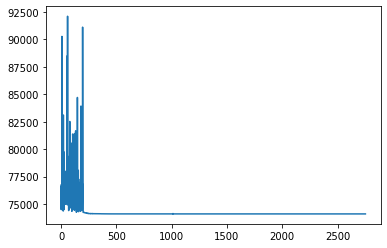

In [172]:
pyplot.plot(testFit["trajectoryLLs"])

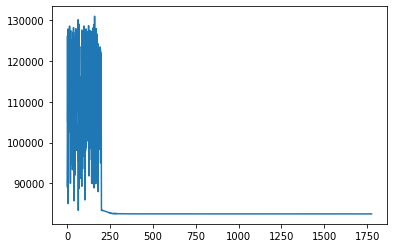

In [291]:
pyplot.plot(testFitLarge["trajectoryLLs"])

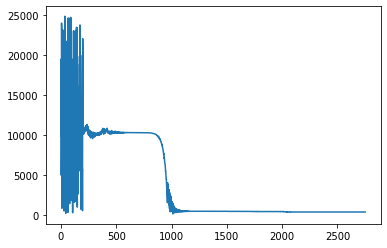

In [173]:
pyplot.plot(ta[:,0])

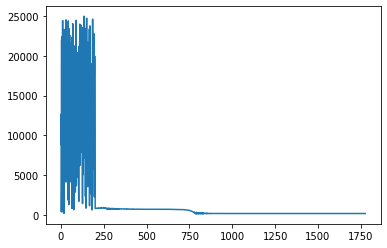

In [292]:
pyplot.plot(taLarge[:,0])

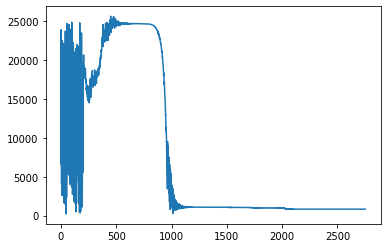

In [174]:
pyplot.plot(ta[:,1])

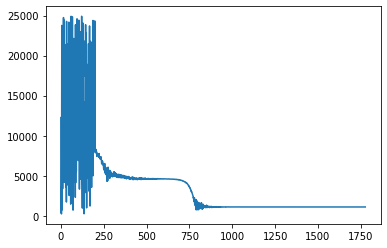

In [293]:
pyplot.plot(taLarge[:,1])

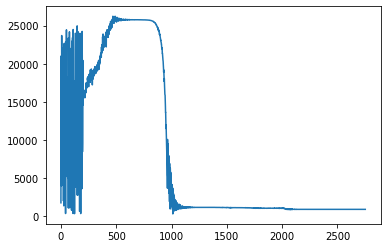

In [175]:
pyplot.plot(ta[:,2])

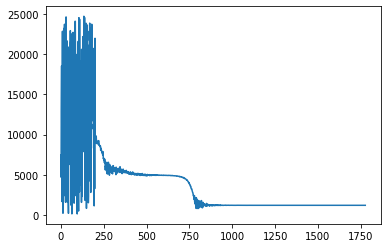

In [294]:
pyplot.plot(taLarge[:,2])

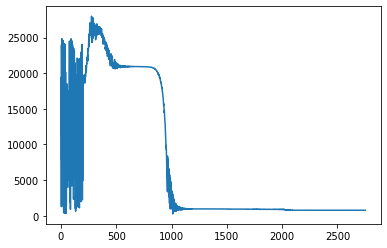

In [176]:
pyplot.plot(ta[:,3])

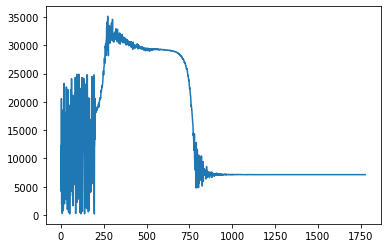

In [295]:
pyplot.plot(taLarge[:,3])

In [296]:
pisTraj = tensor(testFit["trajectoryPi"])
pisTrajLarge = tensor(testFitLarge["trajectoryPi"])

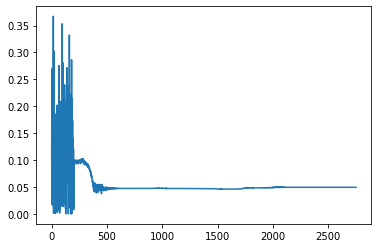

In [178]:
pyplot.plot(pisTraj[:,0])

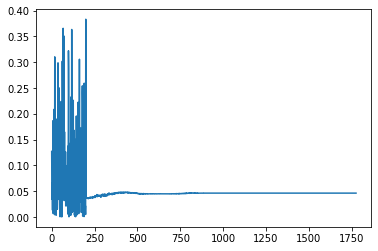

In [297]:
pyplot.plot(pisTrajLarge[:,0])

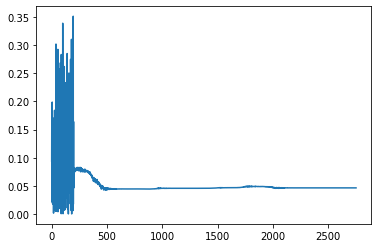

In [179]:
pyplot.plot(pisTraj[:,1])

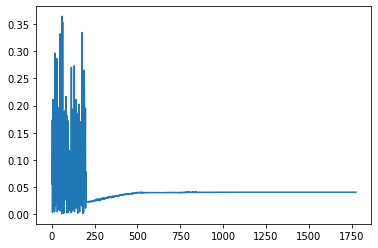

In [298]:
pyplot.plot(pisTrajLarge[:,1])

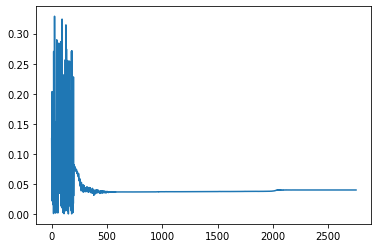

In [180]:
pyplot.plot(pisTraj[:,2])

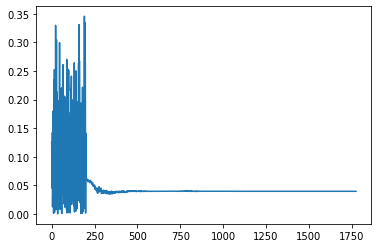

In [299]:
pyplot.plot(pisTrajLarge[:,2])

In [300]:
testCounts = testData["altCounts"]
testCountsLarge = testDataLarge["altCounts"]

In [301]:
testCounts

tensor([[30.,  2.,  1.,  1.],
        [26.,  4.,  0.,  1.],
        [31.,  3.,  0.,  0.],
        ...,
        [33.,  0.,  0.,  1.],
        [27.,  1.,  0.,  1.],
        [24.,  0.,  0.,  0.]], dtype=torch.float64)

In [302]:
testCountsLarge

tensor([[30.,  6.,  2.,  4.],
        [18.,  5.,  1.,  5.],
        [24.,  3.,  0.,  3.],
        ...,
        [29.,  1.,  1.,  1.],
        [29.,  0.,  0.,  0.],
        [22.,  0.,  0.,  0.]], dtype=torch.float64)

In [183]:
rrsMisspecified = tensor([10, 10, 10])

try:
    paramsMisspecified = genData.genParams(rrMeans=rrsMisspecified, pis=pis, afMean=afMean, rrShape=rrShape, afShape=afShape, nCases=nCases, nCtrls=nCtrls)[0]
    testDataMisspecified = generatingFn(**params, covShared=covShared, covSingle=covSingle)
except Exception as e:
    print(f"Run failed: {e}")

pDs are: tensor([0.0309, 0.0309, 0.0123])
TESTING WITH: nCases tensor([10000., 10000.,  4000.]) nCtrls tensor(300000.) rrMeans tensor([1.5000, 1.5000, 1.5000]) rrShape tensor(50.) afMean 0.0001 afShape tensor(50.) diseaseFractions tensor([0.0500, 0.0500, 0.0500]) pDs tensor([0.0309, 0.0309, 0.0123]) covShared tensor([[1.0000, 0.4000, 0.4000],
        [0.4000, 1.0000, 0.4000],
        [0.4000, 0.4000, 1.0000]]) covSingle tensor([[1, 0],
        [0, 1]])


test tensor 1.0,0.4,0.4,0.4,1.0,0.4,0.4,0.4,1.0
tensor([[3.4976, 1.9117, 5.1212],
        [1.0413, 1.6491, 3.9424],
        [3.7569, 3.9536, 6.3573],
        ...,
        [1.2476, 1.6519, 1.0696],
        [3.1667, 2.5180, 5.4168],
        [3.5974, 4.2134, 5.2786]], dtype=torch.float64)
startIndices [0, tensor(1000.), tensor(2000.)] endIndices tensor([1000., 2000., 3000.])
totalSamples 324000


In [354]:
import torch
likelihoodFn, nullLike = likelihoods.effectLikelihood(4, pDs=params["pDs"], altCountsFlat=testData["altCounts"])
pis = tensor(testFit["params"][0][0:3])
piNull = 1 - pis.sum()
alphas = testFit["params"][0][3:]
affectedGenes1 = tensor(testData["affectedGenes"][0])
affectedGenes2 = tensor(testData["affectedGenes"][1])
affectedGenesBoth = tensor(testData["affectedGenes"][2])

unaffectedGenes = testData["unaffectedGenes"]
alphas
mask1 = testData["altCounts"][:,1][affectedGenes1] > 0
affectedGenes1NonNull = torch.nonzero(mask1)
affectedGenes1NonNull.shape

like = likelihoodFn(*alphas)
like

likeWithNull = torch.stack([nullLike, like[:,0], like[:,1], like[:,2]]).T
likeWithNull

pdCtrl, pd1, pd2, pdBoth:  tensor([0.9259, 0.0309, 0.0309, 0.0123], dtype=torch.float64)


tensor([[2.0074e-02, 3.3766e-02, 1.5268e-02, 3.0953e-03],
        [1.2868e-03, 1.3837e-02, 6.8732e-04, 1.6879e-03],
        [1.6189e-02, 3.1906e-02, 2.9415e-03, 4.1956e-04],
        ...,
        [3.3114e-02, 1.4180e-02, 1.2976e-02, 8.1541e-05],
        [3.8733e-02, 4.2336e-02, 1.7855e-02, 1.1432e-03],
        [1.5770e-01, 5.0831e-02, 4.6236e-02, 5.8820e-04]], dtype=torch.float64)

In [355]:
likelihoodFnLarge, nullLikeLarge = likelihoods.effectLikelihood(4, pDs=paramsLarge["pDs"], altCountsFlat=testDataLarge["altCounts"])
pisLarge = tensor(testFitLarge["params"][0][0:3])
piNullLarge = 1 - pisLarge.sum()
alphasLarge = testFitLarge["params"][0][3:]
affectedGenes1Large = tensor(testDataLarge["affectedGenes"][0])
affectedGenes2Large = tensor(testDataLarge["affectedGenes"][1])
affectedGenesBothLarge = tensor(testDataLarge["affectedGenes"][2])

unaffectedGenesLarge = testDataLarge["unaffectedGenes"]
mask1Large = testDataLarge["altCounts"][:,1][affectedGenes1Large] > 0
affectedGenes1NonNullLarge = torch.nonzero(mask1Large)
affectedGenes1NonNullLarge.shape

likeLarge = likelihoodFnLarge(*alphasLarge)
likeLarge

likeLargeWithNull = torch.stack([nullLikeLarge, likeLarge[:,0], likeLarge[:,1], likeLarge[:,2]]).T
likeLargeWithNull

pdCtrl, pd1, pd2, pdBoth:  tensor([0.9259, 0.0309, 0.0309, 0.0123], dtype=torch.float64)


tensor([[2.9136e-07, 3.9622e-03, 9.0206e-06, 6.0266e-14],
        [5.9499e-09, 1.6801e-03, 3.0895e-06, 4.0364e-09],
        [1.0361e-04, 1.2931e-02, 5.5327e-05, 8.1300e-14],
        ...,
        [3.7564e-02, 2.1461e-03, 1.5068e-03, 1.8299e-17],
        [1.0733e-01, 4.1332e-04, 2.6270e-04, 4.3904e-20],
        [1.8394e-01, 2.4454e-03, 1.7249e-03, 1.4618e-15]], dtype=torch.float64)

In [ ]:
values, indices = torch.max(likeLargeWithNull[affectedGenes1Large],1)
maskLarge = indices != 1
badIndices = torch.nonzero(maskLarge)
print("n misclassified:", badIndices.shape, "out of", affectedGenes1Large.shape, "n genes", "is", len(badIndices)/len(affectedGenes1Large))

maskLargeAssumedNull = indices == 0
badIndicesAssumedNull = torch.nonzero(maskLargeAssumedNull)
print("n believed to be null:", badIndicesAssumedNull.shape, "out of", affectedGenes1Large.shape, "n genes", "is", len(badIndicesAssumedNull)/len(affectedGenes1Large))
badIndicesAssumedNull

In [ ]:
values, indices = torch.max(likeWithNull[affectedGenes1],1)
mask = indices != 1
badIndices = torch.nonzero(mask)
print("n misclassified:", badIndices.shape, "out of", affectedGenes1.shape, "genes", "; % correct: ", len(badIndices)/len(affectedGenes1))
badIndices

# maskAssumedNull = indices == 0
# badIndicesAssumedNull = torch.nonzero(maskAssumedNull)
# print("n believed to be null:", badIndicesAssumedNull.shape, "out of", affectedGenes1.shape, "n genes", "is", len(badIndicesAssumedNull)/len(affectedGenes1))
# badIndicesAssumedNull

In [ ]:
maskCount = testData["altCounts"][affectedGenes1, 1] != 0
torch.nonzero(maskCount)

In [381]:
badIdx = 903
print(testData["altCounts"][affectedGenes1][badIdx])
print(likeWithNull[badIdx])

tensor([31.,  0.,  0.,  0.], dtype=torch.float64)
tensor([9.2016e-02, 2.2061e-02, 1.9540e-02, 7.2670e-05], dtype=torch.float64)


In [351]:
print(likeLargeWithNull[102])
print(testDataLarge["altCounts"][102])

tensor([6.2325e-06, 1.4781e-04, 5.4868e-04, 1.7416e-10], dtype=torch.float64)
tensor([23.,  4.,  5.,  1.], dtype=torch.float64)


In [345]:
values, indices = torch.max(likeLargeWithNull[affectedGenesBothLarge],1)
maskLarge = indices != 3
badIndices = torch.nonzero(maskLarge)
print("n misclassified:", badIndices.shape, "out of", affectedGenesBothLarge.shape, "n genes", "is", len(badIndices)/len(affectedGenesBothLarge))
badIndices

n misclassified: torch.Size([2, 1]) out of torch.Size([798]) n genes is 0.002506265664160401


tensor([[287],
        [534]])

In [ ]:
values, indices = torch.max(likeLargeWithNull[affectedGenes2Large],1)
maskLarge = indices != 2
badIndices = torch.nonzero(maskLarge)
print("n misclassified:", badIndices.shape, "out of", affectedGenes2Large.shape, "n genes", "is", len(badIndices)/len(affectedGenes2Large))
badIndices


In [348]:
values, indices = torch.max(likeLargeWithNull[unaffectedGenesLarge],1)
maskLarge = indices != 0
badIndices = torch.nonzero(maskLarge)
print("n misclassified:", badIndices.shape, "out of", len(unaffectedGenesLarge), "n genes", "is", len(badIndices)/len(unaffectedGenesLarge))
badIndices


n misclassified: torch.Size([1375, 1]) out of 17280 n genes is 0.07957175925925926


tensor([[    3],
        [   16],
        [   18],
        ...,
        [17235],
        [17262],
        [17270]])

In [327]:
testDataLarge["altCounts"][982]

tensor([26.,  3.,  2.,  0.], dtype=torch.float64)

In [ ]:
nullLike[affectedGenes1NonNull]

In [ ]:
nullLike[affectedGenes1]

In [266]:
bayesFactorsAffected1 = like[unaffectedGenes].sum(1)/nullLike[unaffectedGenes]

In [274]:
d = bayesFactorsAffected1 < 1
print(torch.nonzero(d).shape)
print(len(unaffectedGenes))

torch.Size([6818, 1])
17000


In [99]:
bayesFactorsAffectedNull1 = like[testUnaffectedGenes,0]/nullLike[testUnaffectedGenes]

In [101]:
bayesFactorsAffectedNull1.min(0)

torch.return_types.min(
values=tensor(0.1546, dtype=torch.float64),
indices=tensor(4985))

In [42]:
testCountMisspecified = testDataMisspecified["altCounts"]

# bayesFactor(n, altCount,pDs,rrMeans,rrsShape,afMeans,afShape,alpha0, alpha1, alpha2, alphaBoth):
bfsAffected1 = []
for affectedGene in testAffectedGenes[0]:
    print(affectedGene, "count:", testCounts[affectedGene])
    testCount = testCountMisspecified[affectedGene]
    bfsAffected1.append(bayes.bayesFactor(testCountMisspecified.sum(), testCountMisspecified, testAllPDs, bestParams[0:3], bestParams[3:]))
bfsAffected1 = tensor(bfsAffected1)

0 count: tensor([34.,  0.,  3.,  0.], dtype=torch.float64)


TypeError: 'NoneType' object is not subscriptable

In [94]:
testData.keys()

dict_keys(['altCounts', 'afs', 'affectedGenes', 'unaffectedGenes', 'rrs'])

In [211]:
import torch
n = testCounts.sum(1).expand(3, len(testCounts)).T
alphas = tensor([1.77041095e+02,
       4.05096749e+02, 3.78310762e+02, 4.93211627e+02])
a0 = alphas[0]
a1 = alphas[1]
a2 = alphas[2]
a3 = alphas[3]
alphas2 = testAllPDs * tensor([[a0,a1,a0,a1], [a0,a0,a1,a1], [a0, a1+a3, a2+a3, a1+a2+a3]])
alphas2 = alphas2.expand(20_000, 3, 4)
print("testCounts.shape",testCounts.shape)
testCounts2 = testCounts.expand(3, 20_000, 4).transpose(0,1)
print("expanded", testCounts.expand(3, 20_000, 4).transpose(0,1).shape)
print(f"shapes: n {n.shape}, alphas: {alphas2.shape} counts: {testCounts2.shape}")

testCounts.shape torch.Size([20000, 4])
expanded torch.Size([20000, 3, 4])
shapes: n torch.Size([20000, 3]), alphas: torch.Size([20000, 3, 4]) counts: torch.Size([20000, 3, 4])


In [190]:
from pyro.distributions import DirichletMultinomial
#. this output is: nGenes by nHypotheses; 1 hypothesis per column
t = DirichletMultinomial(total_count = n, concentration=alphas2).log_prob(testCounts2)
t

shapes torch.Size([20000, 3, 1]) torch.Size([20000, 3, 4])
past


tensor([[ -4.6811,  -7.6378,  -7.5507],
        [ -9.4881, -13.3662,  -7.5881],
        [ -8.8253,  -7.5478,  -5.7675],
        ...,
        [ -3.8760,  -5.3455,  -9.6926],
        [ -5.9153,  -4.3251, -12.1820],
        [ -3.7168,  -5.1863,  -8.7299]], dtype=torch.float64)

In [196]:
t.sum(1).shape

torch.Size([20000])

In [194]:
t[0,2]

tensor(-7.5507, dtype=torch.float64)

In [114]:
# 4 genes, 3 hypothesis
nt = tensor([1,1,1,1]).expand(3,4).T
nt
n.expand(3, len(n)).T[]

tensor([34., 34., 34.], dtype=torch.float64)

In [176]:
r = DirichletMultinomial(total_count=tensor([3., 3, 3.]),concentration=tensor([[1.,2.,3,4],[1.,2,3,4],[1.,2,3,4]])).sample([20_000])

# total_count is hypotheses by 1 , concentration is hypotheses by sampleCategories, output is nGenes by hypotheses by sampleCategories
r.shape

print(r.shape)

# the sample shape is compatible with log_prob
DirichletMultinomial(total_count=tensor([3., 3, 3.]),concentration=tensor([[1.,2.,3,4],[1.,2,3,4],[1.,2,3,4]])).log_prob(r)


shapes torch.Size([3, 1]) torch.Size([3, 4])
past
torch.Size([20000, 3, 4])
shapes torch.Size([3, 1]) torch.Size([3, 4])
past


tensor([[-4.2950, -2.3979, -3.3142],
        [-3.1964, -3.0910, -3.0910],
        [-2.9087, -1.9924, -2.3979],
        ...,
        [-1.9924, -3.0910, -4.7005],
        [-3.1964, -2.2156, -1.9924],
        [-2.3979, -2.2156, -3.0910]])

In [ ]:
def likelihoodBivariateFast(altCountsFlat, pDs, trajectoryPis, trajectoryAlphas, trajectoryLLs):
    nGenes = altCountsByGene.shape[0]

    # nGenes x 4
    xCtrl = altCountsFlat[:, 0]
    xCase1 = altCountsFlat[:, 1]
    xCase2 = altCountsFlat[:, 2]
    xCase12 = altCountsFlat[:, 3]
    # nGenes x 1
    n = xCtrl + xCase1 + xCase2 + xCase12

    pd1 = pDs[0]
    pd2 = pDs[1]
    pdBoth = pDs[2]
    pdCtrl = 1 - pDs.sum()

    pDsAll = tensor([pdCtrl, pd1, pd2, pdBoth], dtype=torch.float64)
    
    print("pdCtrl, pd1, pd2, pdBoth: ", pDsAll)

    allNull2 = nullLikelihood(pDsAll, altCountsFlat)
    allNull2Log = torch.log(allNull2)

    # TODO: make this flexible for multivariate
    nConditions = 4
    nHypothesesNonNull = 3

    altCountsShaped = altCountsFlat.expand(nHypothesesNonNull, nGenes, nConditions).transpose(0, 1)
    nShaped = n.expand(nHypothesesNonNull, nGenes).T
    pdsAllShaped = pDsAll.expand(nHypothesesNonNull, nConditions)
    def jointLikelihood(params):
        pi1, pi2, piBoth, alpha0, alpha1, alpha2, alphaBoth = params

        if alpha0 < 0 or alpha1 < 0 or alpha2 < 0 or alphaBoth < 0 or pi1 < 0 or pi2 < 0 or piBoth < 0:
            return float("inf")

        pi0 = 1.0 - (pi1 + pi2 + piBoth)

        if pi0 < 0:
            return float("inf")

        h0 = pi0 * allNull2

        trajectoryPis.append([pi1, pi2, piBoth])
        trajectoryAlphas.append([alpha0, alpha1, alpha2, alphaBoth])

        concentrations = pdsAllShaped * tensor([
            [alpha0, alpha1, alpha0, alpha1],
            [alpha0, alpha0, alpha2, alpha2],
            [alpha0, alpha1 + alphaBoth, alpha2 + alphaBoth, alpha1 + alpha2 + alphaBoth]
        ]).expand(nGenes, nHypothesesNonNull, nConditions)
        
        hs = tensor([[pi1, pi2, piBoth]]) * torch.exp(DirichletMultinomial(total_count=nShaped, concentration=concentrations).log_prob(altCountsShaped))

        ll = -torch.log(h0 + hs.sum(1)).sum()
        trajectoryLLs.append(ll)
        return ll
    return jointLikelihood

In [479]:
import os
from os import path

folder = '/Users/alexkotlar/projects/tada/2020-05-251590382123'
r = np.load(path.join(folder, 'results_list.npy'), allow_pickle=True)

# print("done", r)

for i in range(len(r)):
    print(f"iteration {i}")
    params = r[i]
#     print("params", params)
    data = np.load(path.join(folder, i.__str__(), 'data.npy'), allow_pickle=True).item()
    runs = data["runs"]
    print(runs[0].keys())
#     print(runs[0]['altCounts'])
#     if 'error' in runs
    altCountsRun = runs[0]['results']["bestRes"]["pis"]
    print(altCountsRun)
#     break
    
    bestPis = []
    bestAlphas = []
    pdv1 = []
    pdv1True = []
    pdv2 = []
    pdvBoth = []
    pdNotv = []
#     altCounts = []
    i = 0
    for run in runs:
#         print(i)
        bestRes = run['results']["bestRes"]
        bestAlphas.append(bestRes['alphas'].numpy())
        print(run["altCounts"][0:1000])
        break
#         print(bestRes)
#         altCounts.append(run["altCounts"][0:1000].numpy())
        
        bestPis.append(bestRes["pis"].numpy())
        pdv1.append(bestRes["PDV_c1inferred"].numpy())
#         print(bestRes["PDV_c1inferred"].numpy())
#         print(bestRes["PDV_cBothTrue"].numpy(), bestRes["PDV_cBothInferred"].numpy())
        pdv1True.append(bestRes["PDV_c1true"].numpy())
        pdv2.append(bestRes["PDV_c2inferred"].numpy())
        pdvBoth.append(bestRes["PDV_cBothInferred"].numpy())
        i += 1
        
    bestPis = tensor(bestPis)
    pdv1 = tensor(pdv1)
    pdv1True = tensor(pdv1True)
    bestAlphas = tensor(bestAlphas)
    
    print("pis:", "mean:", bestPis.mean(0), "std:", bestPis.std(0))
    print('alphas:','median:', bestAlphas.mean(0))
    print("pdv1 inferred:", "mean:", pdv1.mean(0), "std:", pdv1.std(0))
    print("pdv1 true:", "mean:", pdv1True.mean(0), "std:", pdv1True.std(0))
#     print("altcount means", tensor(altCounts).mean(1))
    break

    

iteration 0
dict_keys(['altCounts', 'afs', 'affectedGenes', 'unaffectedGenes', 'generatingFn', 'results'])
tensor([0.0060, 0.0057, 0.0107], dtype=torch.float64)
tensor([[3., 0., 0., 0.],
        [3., 0., 0., 0.],
        [1., 2., 0., 0.],
        ...,
        [3., 0., 0., 0.],
        [2., 0., 0., 0.],
        [2., 0., 0., 0.]], dtype=torch.float64)
pis: mean: tensor(nan) std: tensor(nan)
alphas: median: tensor([  280.3403, 13455.0194, 15702.6012, 93028.1288], dtype=torch.float64)
pdv1 inferred: mean: tensor(nan) std: tensor(nan)
pdv1 true: mean: tensor(nan) std: tensor(nan)


In [666]:
rrsUpscale = tensor([20, 20, 20])
pisUpscale = tensor([.01, .01, .01])
pDsUpscale = tensor([0.0100, 0.0100, 0.0020])
nCasesUpscale = tensor([1e4, 1e4, 4e3])
nCtrlsUpscale = tensor(2e6)
afMeanUpscale = 1e-4
covSharedUpscale = tensor([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]])
covSingleUpscale = tensor([[1, 0],
        [0, 1]])

generatingFn =  genData.v6normal
fitMethod = 'nelder-mead'
nEpochs=1
mt = True

try:
    paramsUpscale = genData.genParams(rrMeans=rrsUpscale, pis=pisUpscale, afMean=afMeanUpscale, rrShape=rrShape, afShape=afShape, nCases=nCasesUpscale, nCtrls=nCtrlsUpscale, pDs=pDsUpscale, covShared=covSharedUpscale, covSingle=covSingleUpscale)[0]
    testDataUpscale = generatingFn(**paramsUpscale)
except Exception as e:
    print(f"Run failed: {e}")

pDs are: tensor([0.0100, 0.0100, 0.0020])
TESTING WITH: nCases tensor([10000., 10000.,  4000.]) nCtrls tensor(2000000.) rrMeans tensor([20, 20, 20]) rrShape tensor(50.) afMean 0.0001 afShape tensor(50.) diseaseFractions tensor([0.0100, 0.0100, 0.0100]) pDs tensor([0.0100, 0.0100, 0.0020]) covShared tensor([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]]) covSingle tensor([[1, 0],
        [0, 1]])


test tensor 1,0,0,0,1,0,0,0,1
tensor([[39.9553, 41.0368, 61.1132],
        [39.7465, 40.2735, 61.6915],
        [39.6398, 38.0867, 60.0413],
        ...,
        [39.1323, 40.3251, 59.1622],
        [39.0603, 41.4878, 60.8894],
        [41.0934, 40.2742, 60.0276]], dtype=torch.float64)
startIndices [0, tensor(200.), tensor(400.)] endIndices tensor([200., 400., 600.])
totalSamples 2024000


In [667]:
print(testDataUpscale["altCounts"].mean(0))
testCountsUpscale = testDataUpscale["altCounts"].mean(0)

tensor([194.6316,   3.2027,   3.1717,   0.7880], dtype=torch.float64)


In [668]:
testDataUpscale["altCounts"]

tensor([[147.,  43.,   1.,   8.],
        [165.,  45.,   4.,  15.],
        [178.,  43.,   2.,   9.],
        ...,
        [131.,   2.,   1.,   2.],
        [142.,   3.,   4.,   0.],
        [237.,   2.,   3.,   0.]], dtype=torch.float64)

In [669]:
print(testDataUpscale["altCounts"].shape)

testFitUpscale = likelihoods.fitFnBivariate(testDataUpscale["altCounts"], paramsUpscale["pDs"], nEpochs=1)

    

torch.Size([20000, 4])
torch.Size([20000, 4])
IN: altCountsFlat torch.Size([20000, 4])
pdCtrl, pd1, pd2, pdBoth:  tensor([0.9780, 0.0100, 0.0100, 0.0020], dtype=torch.float64)
method nelder-mead costFn <function likelihoodBivariateFast.<locals>.jointLikelihood at 0x7f957e154440>
best ll: 109033.66468126149, bestParams: [0.069128215, 0.05666357, 0.049549818, 937.87415, 23846.834, 12701.304, 22054.56]
Epoch took 72.7163360118866


TypeError: string indices must be integers

In [690]:
upscalePis = tensor(testFitUpscale["params"][0][0:3])
upscaleAlphas = tensor(testFitUpscale["params"][0][3:])
print("upscalePis", upscalePis, "upscaleAlphas", upscaleAlphas)

upscalePis tensor([0.0100, 0.0100, 0.0100], dtype=torch.float64) upscaleAlphas tensor([  1184.2417,  30785.4173,  31317.5726, 589286.9084],
       dtype=torch.float64)


In [682]:
piNullUpscale = 1 - upscalePis.sum()

likelihoodFnUpscale, nullLikeUpscale = likelihoods.effectLikelihood(4, pDs=paramsUpscale["pDs"], altCountsFlat=testDataUpscale["altCounts"])


affectedGenes1Upscale = tensor(testDataUpscale["affectedGenes"][0])
affectedGenes2Upscale = tensor(testDataUpscale["affectedGenes"][1])
affectedGenesBothUpscale = tensor(testDataUpscale["affectedGenes"][2])
unaffectedGenesUpscale = testDataUpscale["unaffectedGenes"]


likeUpscale = likelihoodFnUpscale(*upscaleAlphas)
likeUpscale

likeUpscaleWithNull = torch.stack([nullLikeUpscale, likeUpscale[:,0], likeUpscale[:,1], likeUpscale[:,2]]).T
likeUpscaleWithNull

IN: altCountsFlat torch.Size([20000, 4])
pdCtrl, pd1, pd2, pdBoth:  tensor([0.9780, 0.0100, 0.0100, 0.0020], dtype=torch.float64)


tensor([[ 9.1178e-53,  2.4460e-03,  9.2927e-47, 1.6640e-126],
        [ 1.3822e-63,  9.8333e-05,  1.0919e-45, 1.1161e-136],
        [ 1.4849e-50,  1.7088e-03,  1.4303e-45, 1.5538e-153],
        ...,
        [ 2.3431e-03,  1.2769e-12,  3.2573e-14, 2.4153e-136],
        [ 4.1681e-03,  4.8917e-15,  6.0863e-14, 1.6670e-144],
        [ 3.4052e-02,  8.0651e-25,  7.4913e-24, 1.6161e-245]],
       dtype=torch.float64)

In [683]:
valuesUpscale, indicesUpscale = torch.max(likeUpscaleWithNull[affectedGenes1Upscale],1)
maskUpscale = indicesUpscale != 1
badIndicesUpscale = torch.nonzero(maskUpscale)
maskGoodUpscale = indicesUpscale == 1
goodIndicesUpscale = torch.nonzero(maskGoodUpscale)
# print("n misclassified:", badIndicesUpscale.shape, "out of", affectedGenes1Upscale.shape, "n genes", "fraction bad: ", len(badIndicesUpscale)/len(affectedGenes1Upscale))
print("%Correctly classfieid genes affecting 1:", len(goodIndicesUpscale) * 100/len(affectedGenes1Upscale))

maskUpsacelAssumedNull = indicesUpscale != 0
goodIndicesUpscaleAssumedNull = torch.nonzero(maskUpsacelAssumedNull)
print("%Correct classfieid genes affecting 1 if we call correct non-H0:", len(goodIndicesUpscaleAssumedNull) * 100/len(affectedGenes1Upscale))
# maskUpscale

%Correctly classfieid genes affecting 1: 100.0
%Correct classfieid genes affecting 1 if we call correct non-H0: 100.0


In [545]:
valuesUpscale, indicesUpscale = torch.max(likeUpscaleWithNull[affectedGenes2Upscale],1)
maskUpscale = indicesUpscale != 2
badIndicesUpscale = torch.nonzero(maskUpscale)
maskGoodUpscale = indicesUpscale == 2
goodIndicesUpscale = torch.nonzero(maskGoodUpscale)
# print("n misclassified:", badIndicesUpscale.shape, "out of", affectedGenes1Upscale.shape, "n genes", "fraction bad: ", len(badIndicesUpscale)/len(affectedGenes1Upscale))
print("%Correctly classfieid risk genes 2:", len(goodIndicesUpscale) * 100/len(affectedGenes2Upscale))


%Correctly classfieid risk genes 2: 85.5


In [684]:
nullBf, altCountsNullBfPerm = bayes.bfNullGene(upscaleAlphas)

TypeError: genAlleleCount() got an unexpected keyword argument 'nToSample'

In [ ]:
altCountsNullBfPerm[0:100]

In [598]:
mask = nullBf.max(1).values > 1
# print(nullBf.max(1).values)

wrong = torch.nonzero(mask)

print("Wrong %: ", len(wrong) / len(mask))

Wrong %:  0.0023


In [613]:
nullBf.nelement()

30000

In [606]:
t=torch.tensor([[1,2],[3,4]])
r=torch.randperm(2)
c=torch.randperm(2)
t=t[r[:, None], c]
t

tensor([[4, 3],
        [2, 1]])

In [608]:
idx = torch.randperm(t.nelement())
idx

tensor([1, 0, 3, 2])

tensor([27095, 13410, 25369,  ..., 29920, 15399,  7653])

In [609]:
t.nelement()

4

In [626]:
idx2 = torch.randperm(nullBf.nelement())
idx2

nullBfPerm = nullBf.view(-1)[idx2].view(nullBf.size())
nullBfPerm

tensor([[1.3162e-20, 6.5696e-07, 1.5893e-15],
        [6.5757e-07, 8.6326e-13, 5.7114e-13],
        [1.3162e-20, 1.4233e-08, 1.5026e-08],
        ...,
        [9.1238e-08, 6.5240e-11, 1.8144e-07],
        [1.5565e-15, 6.5240e-11, 3.1668e-23],
        [1.1713e-20, 1.4223e-03, 3.3371e-09]], dtype=torch.float64)

In [619]:
testDataUpscale["altCounts"]

tensor([[15.,  3.,  0.,  0.],
        [18.,  6.,  0.,  0.],
        [15.,  3.,  0.,  0.],
        ...,
        [16.,  1.,  0.,  0.],
        [17.,  0.,  1.,  0.],
        [18.,  0.,  1.,  0.]], dtype=torch.float64)

In [638]:
bfPermuted, altCountsPermuted = bayes.permutedGeneCountBFs(testDataUpscale["altCounts"], upscaleAlphas, paramsUpscale["pDs"])

idx [45425 47049 68437 ... 45489   975 75095]
altCountsPermuted tensor([[ 0.,  0.,  0.,  0.],
        [20.,  1., 16.,  0.],
        [ 0., 20.,  1.,  1.],
        ...,
        [ 0.,  0., 20., 21.],
        [ 0., 18., 24., 20.],
        [ 0., 19.,  1.,  0.]], dtype=torch.float64)
pdCtrl, pd1, pd2, pdBoth:  tensor([0.9780, 0.0100, 0.0100, 0.0020], dtype=torch.float64)
bf tensor([[ 1.0000e+00,  1.0000e+00,  1.0000e+00],
        [ 2.0702e+02,  6.8678e+19,  1.0270e+08],
        [ 2.4704e+31,  1.1142e+10,  2.1031e+35],
        ...,
        [ 8.2363e+40,  6.8615e+64,  2.3384e+67],
        [ 2.4948e+68,  2.3120e+74, 7.0584e+100],
        [ 2.5185e+28,  7.6836e+07,  1.1502e+32]], dtype=torch.float64)


In [698]:
bfsUpscaled = bayes.bayesFactors(testDataUpscale["altCounts"],  paramsUpscale["pDs"], upscaleAlphas)
bfsUpscaled.shape

IN: altCountsFlat torch.Size([20000, 4])
pdCtrl, pd1, pd2, pdBoth:  tensor([0.9780, 0.0100, 0.0100, 0.0020], dtype=torch.float64)


torch.Size([20000, 3])

In [720]:
upscaleFDRs = bayes.bayesFDRs(bfsUpscaled, upscalePis)

pis tensor([0.0100, 0.0100, 0.0100], dtype=torch.float64) len 3 shape torch.Size([20000])
[0, 1, 2]
torch.Size([20000])
bfSorted tensor([       inf,        inf,        inf,  ..., 2.9922e-31, 1.4293e-31,
        1.2550e-31], dtype=torch.float64)
bfSorted after tensor([4.8849e+206, 4.8849e+206, 4.8849e+206,  ...,  2.9922e-31,
         1.4293e-31,  1.2550e-31], dtype=torch.float64)
cumsum tensor([4.8849e+206, 9.7697e+206, 1.4655e+207,  ..., 1.9539e+208,
        1.9539e+208, 1.9539e+208], dtype=torch.float64)
qnull tensor([0., 0., 0.,  ..., 1., 1., 1.], dtype=torch.float64)
range tensor([    1,     2,     3,  ..., 19998, 19999, 20000])
fdr tensor([0.0000, 0.0000, 0.0000,  ..., 0.9724, 0.9724, 0.9724],
       dtype=torch.float64)
torch.Size([20000])
bfSorted tensor([       inf,        inf,        inf,  ..., 1.1015e-31, 9.0640e-32,
        1.7466e-33], dtype=torch.float64)
bfSorted after tensor([1.8172e+199, 1.8172e+199, 1.8172e+199,  ...,  1.1015e-31,
         9.0640e-32,  1.7466e-33], dtyp

In [ ]:
bfPermuted[: 100]

In [ ]:
altCountsPermuted[0:100]